# Reproducibility of the approach

_Produces Figure 8_

### Import packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter # for scalars in semilogy labels
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import ConnectionPatch
from scipy.optimize import curve_fit

import numpy as np
from pranzo import Analyzer
from bamboost import Manager

import colors as c
from utilities import set_plot_theme, find_closest_index
set_plot_theme()

### Specify the path to the database

The database can be downloaded from the [ETH Research Collection](https://www.research-collection.ethz.ch/)

In [2]:
database_path = ('../out')

db = Manager(database_path)

### Generate the figure

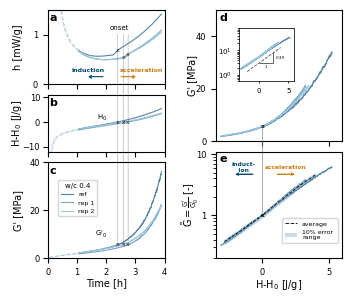

In [3]:
# figure design
fig_reproducibility = plt.figure()
fig_reproducibility.set_size_inches(90/25.4, 90/25.4) # in mm

lft=0.12 #left limit
rgt=0.95 #right limit
bot=0.2 #bottom limit
top=0.9 #top limit

w_ht = 0.33 # width h-t plot
w_DHt = w_ht # width DH-t plot
w_Gt = w_ht # width G-t plot

h_ht = 0.21 # height h-t
h_DHt = 0.12 # height DH-t
h_Gt = 0.27 # height G-t

h_GDH = 0.37 # height G-DH
w_GDH = 0.395

h_GtildeDH = 0.3
w_GtildeDH = w_GDH

hspace=0.04
vspace = 0.03

# axis h-t 
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=lft, right=lft+w_ht, bottom=top-h_ht, top=top)
ax_ht = plt.subplot(gs1[0,0])

# axis DH-t 
gs2 = gridspec.GridSpec(1,1)
gs2.update(left=lft, right=lft+w_DHt, bottom=bot+h_Gt+vspace, top=top-h_ht-vspace)
ax_DHt = plt.subplot(gs2[0,0])

# axis G-t 
gs3 = gridspec.GridSpec(1,1)
gs3.update(left=lft, right=lft+w_Gt, bottom=bot, top=bot+h_Gt)
ax_Gt = plt.subplot(gs3[0,0])

# axis G-DH 
gs4 = gridspec.GridSpec(1,1)
gs4.update(left=rgt-w_GDH+hspace, right=rgt, bottom=top-h_GDH, top=top)
ax_GDH = plt.subplot(gs4[0,0])

inset_GDH = ax_GDH.inset_axes([0.18, 0.46, 0.44, 0.4])

# axis Gtilde-DH 
gs5 = gridspec.GridSpec(1,1)
gs5.update(left=rgt-w_GtildeDH+hspace, right=rgt, bottom=bot, top=bot+h_GtildeDH)
ax_GtildeDH = plt.subplot(gs5[0,0])

# read the data
exps = [
    db['opc40_ref'],
    db['opc40_rep1'],
    db['opc40_rep2'],
]

# set w/c ratios, onset times and colors
wcs = ['ref', 'rep 1', 'rep 2']
onset_times = [8600, 9900, 9300]
colors = [c.blue38, c.blue40, c.blue42]

# initialize empty lists
Gtildes = [] # to compute average after for loop
DHs = []
fit_params = []

# define exponential function for fitting
def expfit(x, a, b):
        return a*np.exp(b*x)

# loop over experiments
for i in range(len(exps)):
    exp = exps[i]
    a = Analyzer(exp)
    
    # markers design
    x_fntsz=4.5
    x_color = '0.1'

    # data for time evolutions
    calo = a.calo
    rheo = a.rheo

    t = np.linspace(0, 4*3500, 20000)
    h = calo.interpolate('norm_heat_flow_Wpgbinder', t) 
    H = calo.interpolate('norm_heat_Jpgbinder', t)
    G = rheo.interpolate('storage_modulus_Pa', t, cutoff=0.012)

    idx_calonoise = find_closest_index(t, 3800)
    idx_bump = find_closest_index(t, onset_times[i])

    # plot h-t with markers
    a.myplot(ax=ax_ht, x=t[:idx_calonoise]*a.nft, y=h[:idx_calonoise]*a.nfh,
            c = colors[i], ls='--', alpha=0.3, xlbl='')
    a.myplot(ax=ax_ht, x=t[idx_calonoise:]*a.nft, y=h[idx_calonoise:]*a.nfh,
            c = colors[i], xlbl='')
    ax_ht.text(t[idx_bump]*a.nft, h[idx_bump]*a.nfh, 'x', color=x_color, fontsize=x_fntsz,
                horizontalalignment='center', verticalalignment='center')
    
    # plot H-H0 - t with markers
    DH_dashed = H[:idx_calonoise] - H[idx_bump]
    DH_full = H[idx_calonoise:] - H[idx_bump]

    # plot DH-t with markers
    a.myplot(ax=ax_DHt,
            x=t[:idx_calonoise]*a.nft,
            y=DH_dashed*a.nfH,
            c=colors[i], ls='--', alpha=0.3, xlbl='')
    a.myplot(ax=ax_DHt,
            x=t[idx_calonoise:]*a.nft,
            y=DH_full*a.nfH,
            c=colors[i], ls='-', alpha=1, xlbl='')
    ax_DHt.text(t[idx_bump]*a.nft, DH_full[idx_bump-idx_calonoise], 'x', color=x_color, fontsize=x_fntsz,
                horizontalalignment='center', verticalalignment='center')
    
    # plot G-t with markers
    G_dashed = G[:idx_calonoise]
    G_full = G[idx_calonoise:]

    a.myplot(ax=ax_Gt, x=t[:idx_calonoise]*a.nft, y=G_dashed*a.nfG,
            c = colors[i], ls='--', alpha=0.3)
    a.myplot(ax=ax_Gt, x=t[idx_calonoise:]*a.nft, y=G_full*a.nfG,
            c = colors[i], label=wcs[i])
    ax_Gt.text(t[idx_bump]*a.nft, G[idx_bump]*a.nfG, 'x', color=x_color, fontsize=x_fntsz,
                horizontalalignment='center', verticalalignment='center')

    # vlines through time evolutions
    c_line_X_t = '0.3'
    xy_ht = (t[idx_bump]*a.nft, h[idx_bump]*a.nfh)
    xy_Gt = (t[idx_bump]*a.nft, G[idx_bump]*a.nfG)
    con = ConnectionPatch(xyA=xy_ht, xyB=xy_Gt, coordsA="data", coordsB="data",
                            axesA=ax_ht, axesB=ax_Gt, color=c_line_X_t,
                            lw=0.4, linestyle='-', alpha=0.5)
    ax_Gt.add_artist(con)

    # text induction, acceleration, H0, G0
    fntsz_onset = 5
    c_bmp = '0.35'
    xy_ht_1 = (t[idx_bump]*a.nft, h[idx_bump]*a.nfh)
    xy_ht_2 = (t[idx_bump]*a.nft, 1)
    bmp = ConnectionPatch(xyA=xy_ht_1, xyB=xy_ht_2, coordsA="data", coordsB="data",
                            axesA=ax_ht, axesB=ax_ht, color=c_bmp,
                            lw=0.4, linestyle='-', alpha=0.5)
    ax_ht.add_artist(bmp)

    if i == 0:
        ax_ht.text(2.1, 1.1, 'onset', fontsize=fntsz_onset)
        ax_DHt.text(1.7, 1, r"H$_0$", fontsize=fntsz_onset)
        ax_Gt.text(1.6, 9, r"$\mathrm{G}'_0$", fontsize=fntsz_onset, weight='bold')

        c_arrow_induct = c.c_opc_34_accel
        c_arrow_accel = c.c_opc_34_onset
        
        ax_ht.text(0.8, 0.26, 'induction', fontsize=fntsz_onset-0.5, color=c_arrow_induct, weight='bold')
        ax_ht.text(2.45, 0.26, 'acceleration', fontsize=fntsz_onset-0.5, color=c_arrow_accel, weight='bold')

        ax_GtildeDH.text(-2.3, 5.2, """induct-
   ion""", fontsize=fntsz_onset-0.7, color=c_arrow_induct, weight='bold')
        ax_GtildeDH.text(0.2, 5.7, 'acceleration', fontsize=fntsz_onset-0.7, color=c_arrow_accel, weight='bold')

    # plot G-DH and Gtilde-DH with markers
    rheo = a.rheo.phase('p2')
    calo = a.calo

    mytime = np.linspace(4000, 3.85*3600, 20000)
    G = rheo.interpolate('storage_modulus_Pa', mytime, cutoff=0.012)
    H = calo.interpolate('norm_heat_Jpgbinder', mytime)
    idx_bump = find_closest_index(mytime, onset_times[i])
    DH = H - H [idx_bump]
    Gtilde = G/G[idx_bump]

    a.myplot(ax=ax_GDH, x=DH*a.nfH, y=G*a.nfG, c=colors[i], xlbl='')
    a.myplot(ax=inset_GDH, x=DH*a.nfH, y=G*a.nfG, type='semilogy',
              xlbl='', ylbl='', c=colors[i])
    a.myplot(ax=ax_GtildeDH, x=DH*a.nfH, y=Gtilde, type='semilogy', 
             c=colors[i], xlbl='')

    ax_GDH.text(DH[idx_bump], G[idx_bump]*a.nfG, 'x', color=x_color, fontsize=x_fntsz,
               horizontalalignment='center', verticalalignment='center')
    ax_GtildeDH.text(DH[idx_bump], Gtilde[idx_bump], 'x', color=x_color, fontsize=x_fntsz,
               horizontalalignment='center', verticalalignment='center')

    # vlines through G-H evolutions
    c_line_X_DH = '0.5'
    xy_GDH = (DH[idx_bump], G[idx_bump]*a.nfG)
    xy_GtildeDH = ((DH[idx_bump], Gtilde[idx_bump]))
    conGDH = ConnectionPatch(xyA=xy_GDH, xyB=xy_GtildeDH, coordsA="data", coordsB="data",
                            axesA=ax_GDH, axesB=ax_GtildeDH, color=c_line_X_DH,
                            lw=0.4, linestyle='-', alpha=0.5)
    ax_GtildeDH.add_artist(conGDH)

    # add arrows below induction and acceleration
    if i == 0:
        arrow_width = 0.4
        ax_ht.arrow(1.9, 0.15, -arrow_width, 0, linewidth=0.4, 
                     head_width=0.07, 
                     head_length=0.1,
                     color=c_arrow_induct)
        
        ax_ht.arrow(2.5, 0.15, arrow_width, 0, linewidth=0.4, 
                     head_width=0.07, 
                     head_length=0.1,
                     color=c_arrow_accel)

        arrow_width_DH = 1.1
        ax_GtildeDH.arrow(-0.7, 4.7, -arrow_width_DH, 0, linewidth=0.5, 
                     head_width=0.5, 
                     head_length=0.2,
                     color=c_arrow_induct)
        
        ax_GtildeDH.arrow(1.1, 4.7, arrow_width_DH, 0, linewidth=0.5, 
                     head_width=0.5, 
                     head_length=0.2,
                     color=c_arrow_accel)

    # couple calo and rheo
    rheo = a.rheo.phase('p2')
    calo = a.calo

    mytime = np.linspace(4000, 3.85*3600, 20000)
    G = rheo.interpolate('storage_modulus_Pa', mytime, cutoff=0.012)
    H = calo.interpolate('norm_heat_Jpgbinder', mytime)
    idx_bump = find_closest_index(mytime, onset_times[i])
    DH = H - H [idx_bump]
    Gtilde = G/G[idx_bump]

    a.myplot(ax=ax_GDH, x=DH*a.nfH, y=G*a.nfG, c=colors[i])
    a.myplot(ax=inset_GDH, x=DH*a.nfH, y=G*a.nfG, type='semilogy', xlbl='',
             ylbl='', c=colors[i])
    a.myplot(ax=ax_GtildeDH, x=DH*a.nfH, y=Gtilde, type='semilogy', c=colors[i])

    Gtildes.append(Gtilde)
    DHs.append(DH)

    # add straight lines with slope in insets
    p, pc = curve_fit(expfit, DH, Gtilde)
    p[1] = 0.39 # here I compare evolution to average from results on all w/c ratios
    xx = np.linspace(DH[0]+0.1, DH[-1]+0.2)
    yy = expfit(xx, p[0], p[1])
    fit_params.append(p)

avg_p0 = 0
avg_p1 = 0
for elem in fit_params:
    avg_p0 += elem[0]
    avg_p1 += elem[1]
avg_p0 = avg_p0/len(fit_params)
avg_p1 = avg_p1/len(fit_params)

c_line = '0.3'
lw_line = 0.6
strt = 5
inset_GDH.semilogy(xx[strt:], yy[strt:]*3, '--', c=c_line, lw=lw_line)

uu = 6
lw_triangle = 0.6
inset_ftsz = 3
a1=1

inset_GDH.vlines(0.4*uu, expfit(uu, p[0], p[1])*0.3, expfit(uu, p[0], p[1])*0.8, lw=lw_triangle, color=c_line)
inset_GDH.hlines(expfit(uu, p[0], p[1])*0.30, 0.0005*uu, 0.4*uu, lw=lw_triangle, color=c_line)

inset_GDH.text(0.45*(uu+0.2), expfit(uu-2.3, p[0], p[1]), str(round(p[1],2)), fontsize=inset_ftsz)
inset_GDH.text(0.2*(uu-1.2), 0.7*expfit(uu-3.5, p[0], p[1]), '1', fontsize=inset_ftsz)

## compute and plot average Gtilde-DeltaH
Gtilde_ref, Gtilde_rep1, Gtilde_rep2 = Gtildes[0], Gtildes[1], Gtildes[2]
DH_ref, DH_rep1, DH_rep2 = DHs[0], DHs[1], DHs[2]

min_length = min(len(Gtilde_ref), len(Gtilde_rep1), len(Gtilde_rep2))
Gtilde_avg = np.mean([Gtilde_ref[:min_length], Gtilde_rep1[:min_length], Gtilde_rep2[:min_length]], axis=0)
DH_avg = np.mean([DH_ref[:min_length], DH_rep1[:min_length], DH_rep2[:min_length]], axis=0)

ax_GtildeDH.semilogy(DH_avg, Gtilde_avg,'--', c='0.1', lw=0.7, label='average')

# compute and plot +- 10%
Gtilde_upper = 1.1*Gtilde_avg
Gtilde_lower = 0.9*Gtilde_avg

ax_GtildeDH.fill_between(DH_avg, Gtilde_lower, Gtilde_upper, 
                        color=c.blue42, alpha=0.6, linewidth=0,
                        label="""10% error 
range""")

# add axes labels
ax_ht.set_ylabel(r"h [mW/g]", labelpad=7)
ax_DHt.set_ylabel(r"H-H$_\mathrm{0}$ [J/g]", labelpad=-1)
ax_Gt.set_ylabel(r"G' [MPa]", labelpad=5)
ax_Gt.set_xlabel(r"Time [h]")

ax_GDH.set_xlabel("")
ax_GDH.set_ylabel(r"G' [MPa]", labelpad=-1)
ax_GtildeDH.set_ylabel(r"$\tilde{\mathrm{G}}=\frac{\mathrm{G}'}{\mathrm{G}_0'}$ [-]", labelpad=-4)
ax_GtildeDH.set_xlabel(r"H-H$_\mathrm{0}$ [J/g]")

# set axes limits
t_min, t_max = 0, 4

ax_ht.set_xlim(t_min, t_max)
ax_DHt.set_xlim(t_min, t_max)
ax_Gt.set_xlim(t_min, t_max)

ax_ht.set_ylim(0, 1.5)
ax_DHt.set_ylim(-12,11)
ax_Gt.set_ylim(0,40)

DH_xmin, DH_xmax = -3.5, 6

ax_GDH.set_xlim(DH_xmin, DH_xmax)
ax_GtildeDH.set_xlim(DH_xmin, DH_xmax)
ax_GDH.set_ylim(0, 50)
ax_GtildeDH.set_ylim(0.2, 11)

inset_GDH.set_xlim(DH_xmin, DH_xmax)
inset_GDH.set_ylim(0.6, 80)

# adjust axes labels and ticks
ax_ht.tick_params(bottom=True, labelbottom=False)
ax_DHt.tick_params(bottom=True, labelbottom=False)
ax_DHt.tick_params(axis='y', pad=2)
ax_Gt.tick_params(axis='y', pad=2)
ax_GDH.tick_params(bottom=True, labelbottom=False)

ax_ht.locator_params(axis='y', nbins=2)
ax_ht.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_DHt.locator_params(axis='y', nbins=2)
ax_Gt.locator_params(axis='y', nbins=2)
ax_Gt.locator_params(axis='x', nbins=4)

ax_GDH.locator_params(axis='x', nbins=3)
ax_GtildeDH.locator_params(axis='x', nbins=3)
ax_GDH.locator_params(axis='y', nbins=4)
inset_GDH.locator_params(axis='x', nbins=3)

inset_GDH.tick_params(axis='x', labelsize=5)
inset_GDH.tick_params(axis='y', labelsize=5)

# make insets nicer
width_inset = 0.55
length_insetticks = 1.6
inset_GDH.tick_params(width=width_inset, which='both', length=length_insetticks)
plt.setp(inset_GDH.spines.values(), lw=width_inset)

# make semilogy yaxis nicer
yticks = [1, 10]
ax_GtildeDH.set_yticks(yticks)
ax_GtildeDH.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# add legend
ax_Gt.legend(title='w/c 0.4', title_fontsize=5, fontsize=4.5,
             bbox_to_anchor=(0.45, 0.4))
ax_GtildeDH.legend(title_fontsize=5, fontsize=4.5,
                  bbox_to_anchor=(0.5, 0.4))

# add subplots labels a, b, c, d, e
fig_reproducibility.text(0.126, 0.87, 'a', fontsize=8, weight='bold')
fig_reproducibility.text(0.125, 0.63, 'b', fontsize=8, weight='bold')
fig_reproducibility.text(0.126, 0.437, 'c', fontsize=8, weight='bold')
fig_reproducibility.text(0.605, 0.87, 'd', fontsize=8, weight='bold')
fig_reproducibility.text(0.605, 0.47, 'e', fontsize=8, weight='bold')

# display figure
plt.show()